In [1]:
import mitsuba as mi
import drjit as dr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

mi.set_variant('cuda_ad_rgb')

from mitsuba import ScalarTransform4f as T

jit_kernel_load(): cache file "/home/viscomp/.drjit/d30246d2dab00df925524d056480522e.cuda.bin" is from an incompatible version of Dr.Jit. You may want to wipe your ~/.drjit directory.
jit_kernel_write(): could not link cache file "/home/viscomp/.drjit/d30246d2dab00df925524d056480522e.cuda.bin" into file system: File exists
jit_kernel_load(): cache file "/home/viscomp/.drjit/c1a001ea8c957bc1a7ed2ccd861bb63a.cuda.bin" is from an incompatible version of Dr.Jit. You may want to wipe your ~/.drjit directory.
jit_kernel_write(): could not link cache file "/home/viscomp/.drjit/c1a001ea8c957bc1a7ed2ccd861bb63a.cuda.bin" into file system: File exists
jit_kernel_load(): cache file "/home/viscomp/.drjit/c1a001ea8c957bc1a7ed2ccd861bb63a.cuda.bin" is from an incompatible version of Dr.Jit. You may want to wipe your ~/.drjit directory.
jit_kernel_write(): could not link cache file "/home/viscomp/.drjit/c1a001ea8c957bc1a7ed2ccd861bb63a.cuda.bin" into file system: File exists


In [2]:
scene = mi.load_dict({
    'type': 'scene',
    'integrator': {
        'type': 'sdf_integrator',
    },
    'sensor': {
        'type': 'perspective',
        'fov': 39.3077,
        'to_world': T.look_at(
            origin=[0, 0, 5],
            target=[0, 0, 0],
            up=[0, 1, 0]
        ),
        'sampler': {
            'type': 'independent',
            'sample_count': 16
        },
        'film': {
            'type': 'hdrfilm',
            'width': 512,
            'height': 512,
            'rfilter': {
                'type': 'gaussian',
            },
            'pixel_format': 'rgb',
            'sample_border': True,
        },
    },
    'sphere': {
        'type': 'sphere',
        'to_world': T.translate([0, 0, 0]),
        'bsdf': {
            'type': 'diffuse',
            'reflectance': {'type': 'rgb', 'value': [0, 1, 0]},
        },
    },
})


def relse(a, b):
    return dr.sqr(a - b) / (dr.sqr(b) + 1e-2)

def relmse(a, b):
    return dr.mean(relse(a, b))

params = mi.traverse(scene)
print(params)
print(params['sensor.x_fov'])

# key = 'sphere.bsdf.reflectance.value'
key = 'sphere.to_world'

SceneParameters[
  ------------------------------------------------------------------------------------
  Name                             Flags    Type  Parent
  ------------------------------------------------------------------------------------
  sensor.near_clip                          float PerspectiveCamera
  sensor.far_clip                           float PerspectiveCamera
  sensor.shutter_open                       float PerspectiveCamera
  sensor.shutter_open_time                  float PerspectiveCamera
  sensor.film.size                          ScalarVector2u HDRFilm
  sensor.film.crop_size                     ScalarVector2u HDRFilm
  sensor.film.crop_offset                   ScalarPoint2u HDRFilm
  sensor.x_fov                     ∂, D     Float PerspectiveCamera
  sensor.to_world                  ∂, D     Transform4f PerspectiveCamera
  sphere.bsdf.reflectance.value    ∂        Color3f SRGBReflectanceSpectrum
  sphere.to_world                  ∂, D     Transform4f Sphere

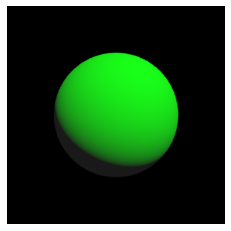

In [3]:
image_ref = mi.render(scene, params, seed=0, spp=1)
plt.axis('off')
plt.imshow(mi.util.convert_to_bitmap(image_ref));

2.0949839138984734 0.0026272002141922712


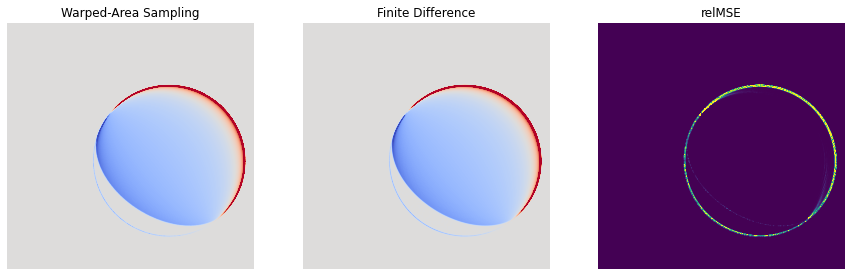

In [4]:
def apply_transformation(params, trans):
    params[key] = mi.Transform4f.translate([trans.x, trans.y, trans.z])
    params.update()

def convert_to_lum(grad_tensor):
    grad_color = dr.unravel(mi.Color3f, dr.ravel(grad_tensor[...,:3]))
    grad_lum = mi.luminance(grad_color)
    return mi.TensorXf(grad_lum, shape=(grad_tensor.shape[0], grad_tensor.shape[1]))

def compute_fd(trans, eps=1e-3, spp=256):
    fd = None
    for c in range(3):
        trans_eps = mi.Vector3f(0)
        trans_eps[c] = eps
    
        apply_transformation(params, trans-trans_eps)
        image1 = mi.render(scene, params, seed=0, spp=spp)

        apply_transformation(params, trans+trans_eps)
        image2 = mi.render(scene, params, seed=0, spp=spp)

        if fd is None:
            fd = dr.zeros(mi.TensorXf, shape=image1.shape)
        fd += (image2 - image1) / (2 * eps)
    return fd

scene.integrator().reparam_𝜆d = 1e2
scene.integrator().reparam_exp = 10

trans = mi.Vector3f(0.5, -0.2, 0.3)
dr.enable_grad(trans)
apply_transformation(params, trans)

image = mi.render(scene, params, seed=0, spp=16)

dr.forward(trans)

# Fetch the image gradient values
grad_image = dr.grad(image)
grad_image_lum = convert_to_lum(grad_image)
fd_image = compute_fd(trans)
fd_image_lum = convert_to_lum(fd_image)
err_image = relse(grad_image, fd_image)
err_image_lum = convert_to_lum(err_image)

cmap = cm.coolwarm
vlim = np.quantile(dr.abs(grad_image_lum), 0.995)
err_vmax = np.quantile(err_image_lum, 0.995)

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 15))
[axi.set_axis_off() for axi in ax.ravel()]
ax[0].imshow(grad_image_lum, cmap=cm.coolwarm, vmin=-vlim, vmax=vlim);
ax[0].set_title("Warped-Area Sampling");
ax[1].imshow(fd_image_lum, cmap=cm.coolwarm, vmin=-vlim, vmax=vlim);
ax[1].set_title("Finite Difference");
ax[2].imshow(err_image_lum, cmap=cm.viridis, vmin=0, vmax=err_vmax);
ax[2].set_title("relMSE");

print(vlim, dr.mean(err_image)[0])

Iteration 249 -- loss 3.898e-05 --
[[0.0005255917785689235, 0.0013178481021896005, -0.0062866052612662315]]


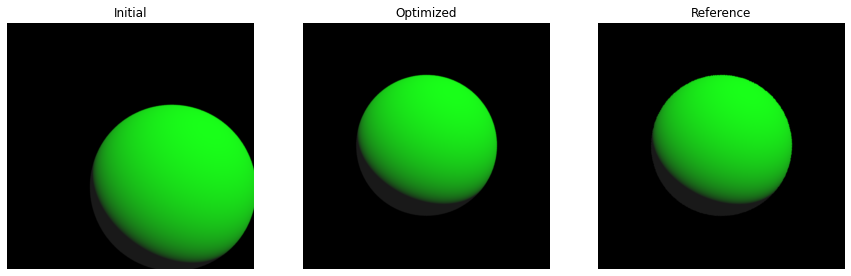

In [5]:
opt = mi.ad.Adam(lr=0.01)
opt['trans'] = mi.Vector3f(0.5, -0.5, 0.7)

scene.integrator().reparam_𝜆d = 1e-1
scene.integrator().reparam_exp = 4

def apply_transformation(params, opt):
    params[key] = mi.Transform4f.translate([opt['trans'].x, opt['trans'].y, opt['trans'].z])
    params.update()

apply_transformation(params, opt)
image_initial = mi.render(scene, params, seed=0, spp=16)

losses = []
for i in range(250):
    apply_transformation(params, opt)

    image = mi.render(scene, params, seed=0, spp=1)

    loss = relmse(image, image_ref)
    dr.backward(loss)
    
    # trans_grad = mi.Vector3f(0)
    
    # for c in range(3):
    #     grad_in = mi.Vector3f(0, 0, 0)
    #     grad_in[c] = 1
    #     dr.set_grad(opt['trans'], grad_in)
    #     dr.enqueue(dr.ADMode.Forward, opt['trans'])
    #     dr.traverse(type(opt['trans']), dr.ADMode.Forward, flags=dr.ADFlag.ClearVertices)
    #     trans_grad[c] = dr.grad(loss)

    # dr.set_grad(opt['trans'], trans_grad)

    opt.step()

    losses.append(loss[0])
    print(f'Iteration {i} -- loss {loss[0]:.3e} --', end='\r')
print()

image = mi.render(scene, params, seed=0, spp=16)

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 15))
[axi.set_axis_off() for axi in ax.ravel()]
ax[0].imshow(mi.util.convert_to_bitmap(image_initial));
ax[0].set_title("Initial");
ax[1].imshow(mi.util.convert_to_bitmap(image));
ax[1].set_title("Optimized");
ax[2].imshow(mi.util.convert_to_bitmap(image_ref));
ax[2].set_title("Reference");

print(opt['trans'])

In [6]:
from mitsuba import Transform4f as T4f

def eval(position):
    T = T4f.translate([1, 2, 3]).rotate(dr.normalize(mi.Point3f(0.2, 0.3, 0.4)), 0.2)
    scale = 2

    T_inv = T.inverse()
    transformed_p = T_inv.transform_affine(position)
    p = transformed_p / scale
    norm_p = dr.norm(p)

    f = scale * (norm_p - 1.0)
    p_norm = dr.select(dr.neq(norm_p, 0), p / norm_p, 0)
    A_inv = mi.Matrix3f(T_inv.matrix)
    A_invT = dr.transpose(A_inv)
    dfdx = A_invT@p_norm

    dfdx2 = dr.detach(dfdx)
    dfdx_outer = mi.Matrix3f(dfdx2 * dfdx2[0], dfdx2 * dfdx2[1], dfdx2 * dfdx2[2])
    denom = norm_p * scale
    dfdxx = dr.select(dr.neq(norm_p, 0), (1 - dfdx_outer) / denom, 0)

    return f, dfdx, dfdxx

p = mi.Point3f(1, 2, 3)
dr.enable_grad(p)

f, n, dndx_analytic = eval(p)
# dr.backward(f)
# dfdx = dr.grad(p)

dndx = mi.Matrix3f(0)
for i in range(3):
    f, n, dndx_analytic = eval(p)
    dr.forward(p[i])
    dndx[i] = dr.grad(n)
print(f, n)
# print(dfdx)
# print(n)

print(dndx)
print(dndx_analytic)


[-1.999999761581421] [[-0.07708980143070221, -0.8744156956672668, -0.4790138304233551]]
[[[3986185.25, -270309.34375, -148078.21875],
  [-270309.34375, 943946.625, -1679624.375],
  [-148078.203125, -1679624.375, 3089900.75]]]
[[[3986185.5, -270309.3125, -148078.203125],
  [-270309.3125, 943946.6875, -1679624.25],
  [-148078.203125, -1679624.25, 3089900.75]]]


In [7]:
def normalize_grad(v):
    norm = dr.norm(v)
    inv_norm = dr.select(dr.neq(norm, 0), 1 / norm, 0)
    s = v * inv_norm
    sos = mi.Matrix3f(s * s[0], s * s[1], s * s[2])
    return inv_norm * (1 - sos)

film_size = mi.ScalarVector2i(100, 80)
crop_size = mi.ScalarVector2i(100, 80)
to_world = T4f.translate([1, 2, 3]).rotate(dr.normalize(mi.Point3f(0.2, 0.3, 0.4)), 0.2)

m_principal_point_offset = mi.Vector2i(0)
fov_x = 40
camera_to_sample = mi.perspective_projection(film_size, crop_size, mi.ScalarVector2i(0, 0), fov_x, 0.1, 1000)
sample_to_camera = camera_to_sample.inverse()

scaled_principal_point_offset = film_size * m_principal_point_offset // crop_size

def u_to_d(u):
    near_p = sample_to_camera @ \
            mi.Point3f(u.x + scaled_principal_point_offset.x,
                      u.y + scaled_principal_point_offset.y,
                      0)

    d = dr.normalize(mi.Vector3f(near_p))
    d = to_world @ d

    dddu = mi.Matrix3f(to_world.matrix) \
        @ normalize_grad(near_p) \
        @ dr.transpose(mi.Matrix3f(sample_to_camera.matrix)) \
        / sample_to_camera.matrix[3,3]

    w = 2*dr.tan(dr.deg2rad(fov_x)/2)
    aspect = film_size.x / film_size.y
    plane_p = mi.Vector3f(((1-u.x) - 0.5) * w, (1 - u.y - 0.5) * w / aspect, 1)
    dddu = mi.Matrix3f(to_world.matrix) @ normalize_grad(plane_p) @ mi.Matrix3f(-w, 0, 0, 0, -w/aspect, 0, 0, 0, 0)

    return d, dddu

def d_to_u(d):   
    u = camera_to_sample @ (mi.Matrix3f(to_world.inverse().matrix) @ d)
    u = mi.Vector2f(u.x, u.y)

    # du_dd = mi.Matrix3f(camera_to_sample.matrix)@mi.Matrix3f(to_world.inverse().matrix)
    w = 2*dr.tan(dr.deg2rad(fov_x)/2)
    aspect = film_size.x / film_size.y
    ax = 1.0/w
    ay = ax*aspect

    x = mi.Matrix3f(to_world.inverse().matrix) @ d

    du_dd = mi.Matrix3f(
        -ax / x.z, 0, ax * x.x / x.z**2,
        0, -ay / x.z, ay * x.y / x.z**2,
        0, 0, 0) @ mi.Matrix3f(to_world.inverse().matrix)

    return u, du_dd

position_sample = mi.Vector2f(0.2, 0.4)
dr.enable_grad(position_sample)
dir, d_dir_du_analytic = u_to_d(position_sample)
# print(dir, d_dir_du_analytic)
u = d_to_u(dir)

d_dir_du = mi.Matrix3f(0)
for i in range(2):
    dir, d_dir_du_analytic = u_to_d(position_sample)
    dr.forward(position_sample[i])
    d_dir_du[i] = dr.grad(dir)

du_ddir = mi.Matrix3f(0)
dir = dr.detach(dir)
dr.enable_grad(dir)
for i in range(3):
    u, du_dd = d_to_u(dir)
    dr.forward(dir[i])
    du_ddir[i] = mi.Vector3f(dr.grad(u).x, dr.grad(u).y, 0)
du_ddir_analytic = mi.Matrix3f(dr.inverse(mi.Matrix2f(dr.transpose(d_dir_du_analytic)@d_dir_du_analytic)))@dr.transpose(d_dir_du_analytic)

print(u)
print(d_dir_du)
print(d_dir_du_analytic)
print(du_ddir)
print(du_ddir_analytic)
print(du_dd)
print(mi.Vector3f(1, 1, 1)@dr.transpose(du_ddir))

[[0.20000000298023224, 0.40000006556510925]]
[[[-0.6775466799736023, 0.008401324041187763, 0.0],
  [0.006641804706305265, -0.5662128329277039, 0.0],
  [0.14885009825229645, 0.030722573399543762, 0.0]]]
[[[-0.6775466203689575, 0.008401324972510338, 0.0],
  [0.006641806103289127, -0.5662128925323486, 0.0],
  [0.14885006844997406, 0.03072257898747921, 0.0]]]
[[[-1.4077826738357544, -0.00405138311907649, 0.31030240654945374],
  [0.004761893767863512, -1.7606110572814941, 0.10023524612188339],
  [0.0, 0.0, 0.0]]]
[[[-1.4077826738357544, -0.004051388241350651, 0.31030240654945374],
  [0.0047618853859603405, -1.7606109380722046, 0.10023531317710876],
  [0.0, 0.0, 0.0]]]
[[[-1.4077825546264648, -0.004051382653415203, 0.3103024363517761],
  [0.00476189237087965, -1.760610818862915, 0.10023527592420578],
  [0.0, 0.0, 0.0]]]
[[-1.1015316247940063, -1.655613899230957, 0.0]]


In [8]:
def normalize_grad(v):
    norm = dr.norm(v)
    inv_norm = dr.select(dr.neq(norm, 0), 1 / norm, 0)
    s = v * inv_norm
    sos = mi.Matrix3f(s * s[0], s * s[1], s * s[2])
    return inv_norm * (1 - sos)

film_size = mi.ScalarVector2i(100, 80)
crop_size = mi.ScalarVector2i(100, 80)
to_world = T4f.translate([1, 2, 3]).rotate(dr.normalize(mi.Point3f(0.2, 0.3, 0.4)), 0.2)
# to_world = T4f.translate([0, 0, 0])

m_principal_point_offset = mi.Vector2i(0)
fov_x = 40
camera_to_sample = mi.perspective_projection(film_size, crop_size, mi.ScalarVector2i(0, 0), fov_x, 0.1, 1000)
sample_to_camera = camera_to_sample.inverse()

scaled_principal_point_offset = film_size * m_principal_point_offset // crop_size

def x_to_u(x):
    u = camera_to_sample @ (to_world.inverse() @ x)
    u = mi.Vector2f(u.x, u.y)
    return u

def compute_du_dx(x):
    w = 2*dr.tan(dr.deg2rad(fov_x)/2)
    aspect = film_size.x / film_size.y
    ax = 1.0/w
    ay = ax*aspect

    x = to_world.inverse() @ x

    du_dx = mi.Matrix3f(
        -ax / x.z, 0, ax * x.x / x.z**2,
        0, -ay / x.z, ay * x.y / x.z**2,
        0, 0, 0) @ mi.Matrix3f(to_world.inverse().matrix)

    return du_dx

x = mi.Point3f(3, 1, 2)
u = x_to_u(x)
print(u)

du_dx = mi.Matrix3f(0)
x = dr.detach(x)
dr.enable_grad(x)
for i in range(3):
    u = x_to_u(x)
    dr.forward(x[i])
    du_dx[i] = mi.Vector3f(dr.grad(u).x, dr.grad(u).y, 0)

print(du_dx)
print(compute_du_dx(x))

[[3.260895013809204, -1.2373124361038208]]
[[[1.3862988948822021, -8.766065548115876e-06, 2.772606134414673],
  [-0.007872242480516434, 1.7283830642700195, -1.744127869606018],
  [0.0, 0.0, 0.0]]]
[[[1.3862987756729126, -8.766602149989922e-06, 2.772606134414673],
  [-0.007872241549193859, 1.72838294506073, -1.7441277503967285],
  [0.0, 0.0, 0.0]]]


In [9]:
def abs_grad(x):
    return dr.select(x >= 0, 1, -1)

def eval_scene(position, translation):
    T = T4f.translate(translation).rotate(dr.normalize(mi.Point3f(0.2, 0.3, 0.4)), 0.2)
    scale = 2

    T_inv = T.inverse()
    transformed_p = T_inv.transform_affine(position)
    p = transformed_p / scale
    norm_p = dr.norm(p)

    f = scale * (norm_p - 1.0)
    p_norm = dr.select(dr.neq(norm_p, 0), p / norm_p, 0)
    A_inv = mi.Matrix3f(T_inv.matrix)
    A_invT = dr.transpose(A_inv)
    dfdx = A_invT@p_norm

    dfdx2 = dr.detach(dfdx)
    dfdx_outer = mi.Matrix3f(dfdx2 * dfdx2[0], dfdx2 * dfdx2[1], dfdx2 * dfdx2[2])
    denom = norm_p * scale
    dfdxx = dr.select(dr.neq(norm_p, 0), (1 - dfdx_outer) / denom, 0)

    return f, dfdx, dfdxx

film_size = mi.ScalarVector2i(100, 80)
crop_size = mi.ScalarVector2i(100, 80)
to_world = T4f.translate([1, 2, 3]).rotate(dr.normalize(mi.Point3f(0.2, 0.3, 0.4)), 0.2)

m_principal_point_offset = mi.Vector2i(0)
camera_to_sample = mi.perspective_projection(film_size, crop_size, mi.ScalarVector2i(0, 0), 40, 0.1, 1000)
sample_to_camera = camera_to_sample.inverse()
camera_to_world = T4f.translate([1, 2, 3]).rotate(dr.normalize(mi.Point3f(0.2, 0.3, 0.4)), 0.2)

scaled_principal_point_offset = film_size * m_principal_point_offset // crop_size

def u_to_d(u):
    near_p = sample_to_camera @ \
            mi.Point3f(u.x + scaled_principal_point_offset.x,
                      u.y + scaled_principal_point_offset.y,
                      0)

    d = dr.normalize(mi.Vector3f(near_p))
    d = to_world @ d

    return d

def _sample_warp_field(translation: mi.Vector3f,
                        u: mi.Vector2f,
                        pos: mi.Point3f,
                        dir: mi.Vector3f,
                        t: mi.Float):
    exponent = 2
    𝜆d = 1e-1

    f, dfdx, dfdxx = eval_scene(pos, translation)
    dfdx = dr.detach(dfdx)

    with dr.suspend_grad():
        sil_dot = dr.dot(dfdx, dir)
        S = dr.abs(f) + 𝜆d * dr.abs(sil_dot)
        w = dr.select(S > 1e-4, dr.power(dr.rcp(S), exponent), 0.0)

        near_p = sample_to_camera @ mi.Point3f(u.x, u.y, 0)
        ddir_du = mi.Matrix3f(camera_to_world.matrix) \
            @ normalize_grad(near_p) \
            @ dr.transpose(mi.Matrix3f(sample_to_camera.matrix)) \
            / sample_to_camera.matrix[3,3]
        
        dx_du = t * ddir_du
        dx_du_t = dr.transpose(dx_du)
        du_dx = dr.select(dr.neq(t, 0), mi.Matrix3f(dr.inverse(mi.Matrix2f(dx_du_t @ dx_du))) @ dx_du_t, 0)
        print('du_dx', du_dx)

        width = 2*dr.tan(dr.deg2rad(fov_x)/2)
        aspect = film_size.x / film_size.y
        plane_p = mi.Vector3f(((1-u.x) - 0.5) * width, (1 - u.y - 0.5) * width / aspect, 1)
        ddir_du = mi.Matrix3f(camera_to_world.matrix) @ normalize_grad(plane_p) @ mi.Matrix3f(-width, 0, 0, 0, -width/aspect, 0, 0, 0, 0)
        
        dx_du = t * ddir_du
        ax = 1.0/width
        ay = ax*aspect
        x = camera_to_world.inverse() @ pos
        du_dx = mi.Matrix3f(
            -ax / x.z, 0, ax * x.x / x.z**2,
            0, -ay / x.z, ay * x.y / x.z**2,
            0, 0, 0) @ mi.Matrix3f(camera_to_world.inverse().matrix)
        print(du_dx)

        da_df = abs_grad(f)
        da_dsildot = abs_grad(sil_dot)

        ds_du = da_df * dfdx @ dx_du + 𝜆d * da_dsildot * (dfdx @ ddir_du + dir @ dfdxx @ dx_du)
        ds_du = mi.Vector2f(ds_du.x, ds_du.y)
        dw_du = -exponent * dr.select(S > 1e-4, dr.power(dr.rcp(S), exponent+1), 0.0) * ds_du

    V_direct = -f * du_dx @ dfdx / dr.dot(dfdx, dfdx)
    V_direct = mi.Vector2f(V_direct.x, V_direct.y)

    return w, dw_du, w * V_direct, dr.dot(dw_du, V_direct)

def compute_w(translation: mi.Vector3f,
                        u: mi.Vector2f,
                        pos: mi.Vector3f,
                        dir: mi.Vector3f,
                        t: mi.Float):
    exponent = 2
    𝜆d = 1e-1

    f, dfdx, dfdxx = eval_scene(pos, translation)

    sil_dot = dr.dot(dfdx, dir)
    S = dr.abs(f) + 𝜆d * dr.abs(sil_dot)
    w = dr.select(S > 1e-4, dr.power(dr.rcp(S), exponent), 0.0)

    return w

translation = mi.Vector3f(0.5, -0.2, 2)

u = mi.Point2f(0.1, 0.5)
dr.enable_grad(u)
dir = u_to_d(u)
o = mi.Point3f(1, 2, 3)
t = 1
pos = mi.Point3f(o + t * dir)

w, dw_du, w_V, div = _sample_warp_field(translation, u, pos, dir, t)

print(w, dw_du, w_V, div)

u = mi.Point2f(0.1, 0.5)
dr.enable_grad(u)
dir = u_to_d(u)
o = mi.Point3f(1, 2, 3)
t = 1
pos = mi.Point3f(o + t * dir)
w = compute_w(translation, u, pos, dir, t)
dr.backward(w)
print(dr.grad(u))

du_dx [[[-1.4299708604812622, -0.004250585101544857, 0.4193905293941498],
  [0.004634917713701725, -1.788478970527649, -0.00232308404520154],
  [0.0, 0.0, 0.0]]]
[[-1.0148310661315918, -1.7861675024032593, 0.0]]
[0.8021252155303955] [[0.06974779814481735, 0.6247949600219727]] [[0.08408600836992264, 1.0849438905715942]] [0.8524009585380554]
[[0.06974776834249496, 0.6247948408126831]]
